In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import maxabs_scale, minmax_scale
from sklearn.metrics import classification_report, confusion_matrix

from scipy import signal

import librosa
import librosa.display

import scipy.interpolate as interpolate

import os
import os.path as path
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5'

In [2]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [3]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [4]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [5]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [6]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_DO_075_DO'

i = 8
model_name = base+'_{}_conv'.format(i)
print()
print(model_name, 'Model')
model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]

model = load_model(model_filename)
model.summary()

[loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
print('Loss:', loss, 'Accuracy:', accuracy)

# del(model)


1D_CNN_custom_ch_32_DO_075_DO_8_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_68 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 5333, 32)          0     

---

In [7]:
def deprocess_wav(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x = np.clip(x, -1, 1)
    return x

In [12]:
y_table[:,0]

array(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
       'eight', 'nine', 'bed', 'bird', 'cat', 'dog', 'house', 'tree'],
      dtype='<U5')

In [8]:
def generate_grad_cam(img_tensor, model, class_index, activation_layer):
    """
    params:
    -------
    img_tensor: resnet50 모델의 이미지 전처리를 통한 image tensor
    model: pretrained resnet50 모델 (include_top=True)
    class_index: 이미지넷 정답 레이블
    activation_layer: 시각화하려는 레이어 이름

    return:
    grad_cam: grad_cam 히트맵
    """
    inp = model.input
    y_c = model.output.op.inputs[0][0, class_index]
    A_k = model.get_layer(activation_layer).output

    ## 이미지 텐서를 입력해서
    ## 해당 액티베이션 레이어의 아웃풋(a_k)과
    ## 소프트맥스 함수 인풋의 a_k에 대한 gradient를 구한다.
    get_output = K.function([inp], [A_k, K.gradients(y_c, A_k)[0], model.output])
    [conv_output, grad_val, model_output] = get_output([img_tensor])

    ## 배치 사이즈가 1이므로 배치 차원을 없앤다.
    conv_output = conv_output[0]
    grad_val = grad_val[0]

    ## 구한 gradient를 픽셀 가로세로로 평균내서 a^c_k를 구한다.
    weights = np.mean(grad_val, axis=0)

    ## 추출한 conv_output에 weight를 곱하고 합하여 grad_cam을 얻는다.
    grad_cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:1])
    for k, w in enumerate(weights):
        grad_cam += w * conv_output[:, k]
        
#     plt.figure()
#     plt.plot(np.maximum(grad_cam, 0))
#     plt.show()

    grad_cam_interp = interpolate.interp1d(np.arange(grad_cam.size),grad_cam, kind='zero')
    grad_cam = grad_cam_interp(np.linspace(0,grad_cam.size-1,16000))

    ## ReLU를 씌워 음수를 0으로 만든다.
    grad_cam = np.maximum(grad_cam, 0)

    grad_cam = grad_cam / (grad_cam.max() + 1e-10)
    return grad_cam

In [11]:
y_test_onehot[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [15]:
model.layers[-5].name

'activation_74'

In [48]:
np.linspace(0,grad_cam.size-1,16000)

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.5997e+04, 1.5998e+04,
       1.5999e+04])

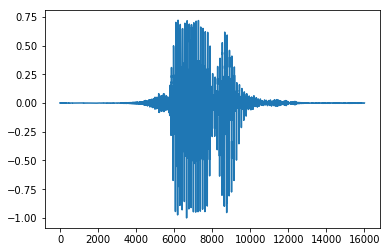

In [17]:
plt.figure()
plt.plot(x_test_abs[1].reshape(16000))

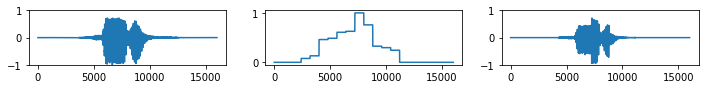

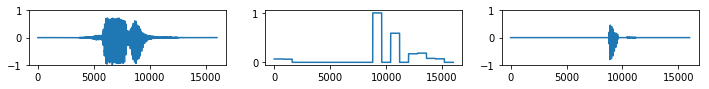

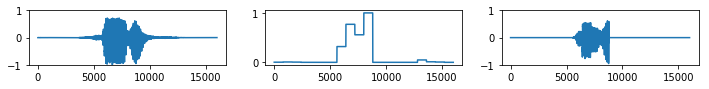

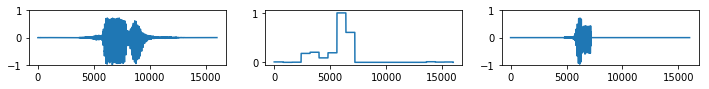

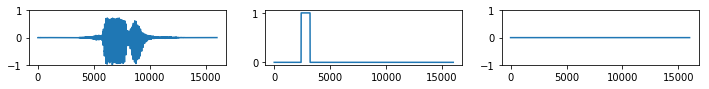

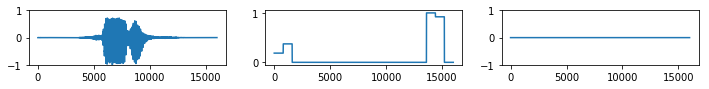

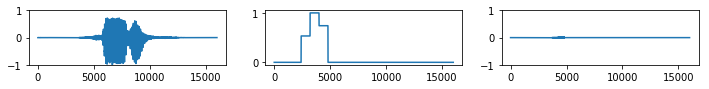

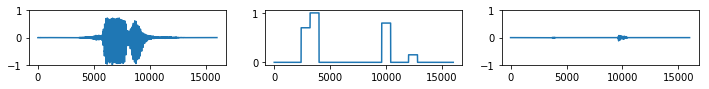

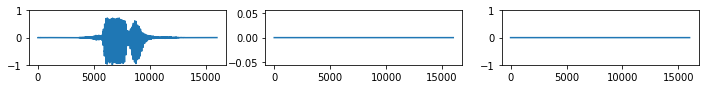

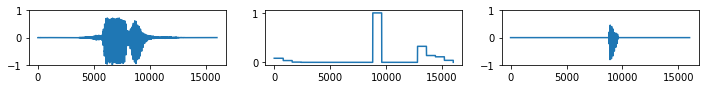

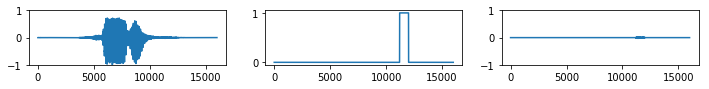

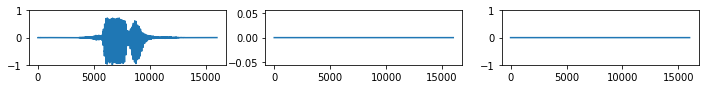

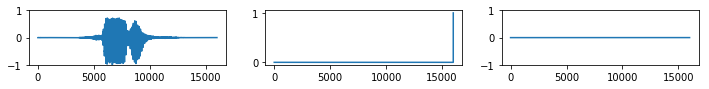

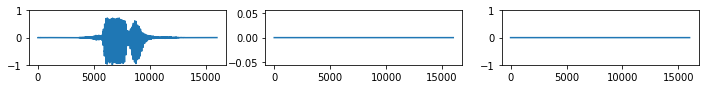

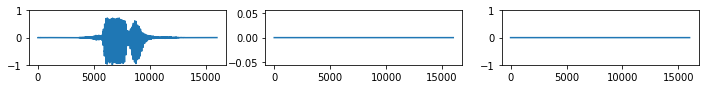

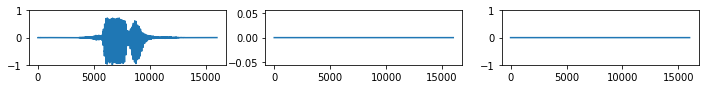

In [11]:
img_tensor = x_test_abs[1].reshape(1, *x_test_abs[1].shape)
activation_layer = 'activation_74'
image_output_base = 'visualization/1D_CNN_custom_ch_32_DO_075_DO/gradcam/'
os.makedirs(image_output_base, exist_ok=True)

for class_index in range(16):
    result = generate_grad_cam(img_tensor, model, class_index, activation_layer)

    plt.figure(figsize=(12, 1))
    plt.subplot(1,3,1)
    plt.ylim(-1,1)
    plt.plot(x_test_abs[1].squeeze())

    plt.subplot(1,3,2)
    plt.plot(result)

    plt.subplot(1,3,3)
    plt.ylim(-1,1)
    plt.plot(x_test_abs[1].squeeze() * result)
    plt.savefig(image_output_base+'sample_{}_layer_{}th_{}_base'.format('output', 
                                               str(class_index).zfill(2), 
                                               'zero'))
    plt.show()

In [173]:
img_tensor = x_test_abs[1].reshape(1, *x_test_abs[1].shape)
activation_layer = 'activation_74'

result = generate_grad_cam(img_tensor, model, class_index, activation_layer)

plt.figure(figsize=(12, 1))

plt.subplot(1,3,1)
plt.plot(x_test_abs[1].squeeze())

plt.subplot(1,3,2)
plt.plot(result)

plt.subplot(1,3,3)
plt.plot(x_test_abs[1].squeeze() * result)
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'subtitle'

<Figure size 864x72 with 0 Axes>

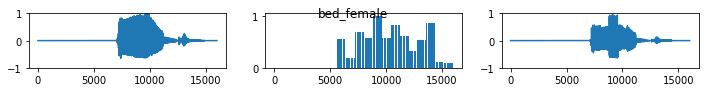

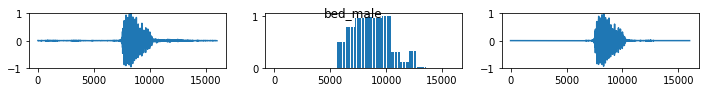

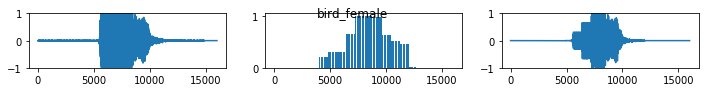

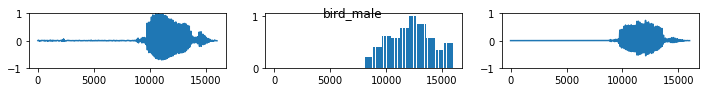

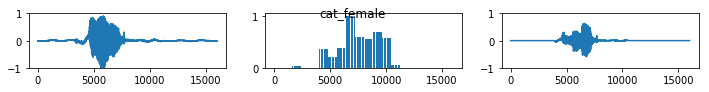

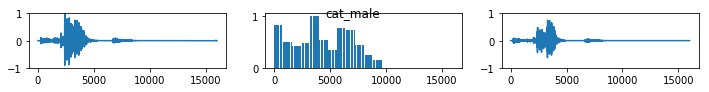

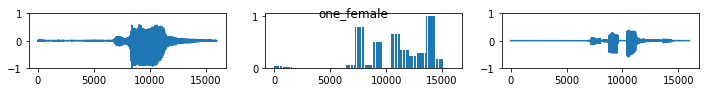

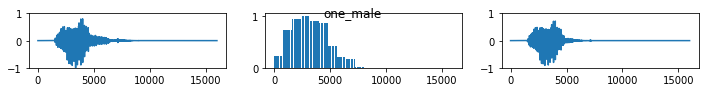

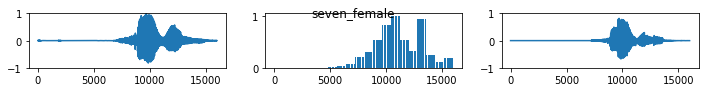

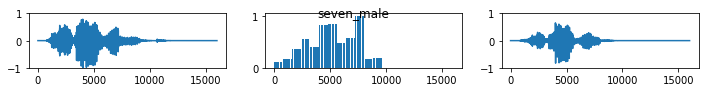

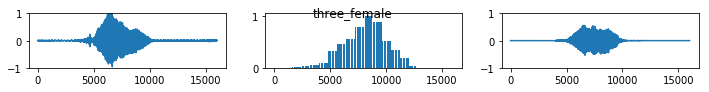

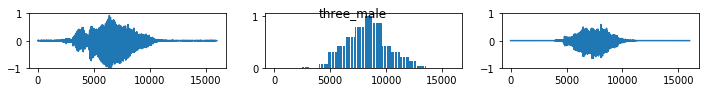

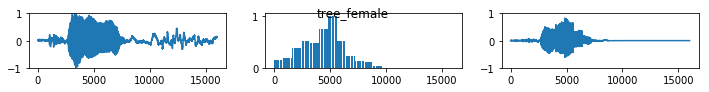

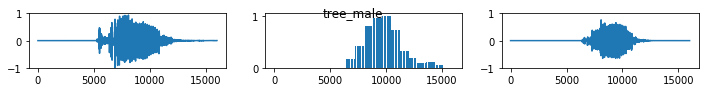

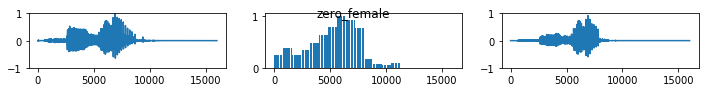

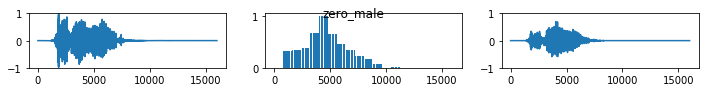

In [15]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'sample_8class')

y_dict = {label:int(numb) for label, numb in y_table}

audio_output_base = 'gradcam_audio/'
image_output_base = 'visualization/1D_CNN_custom_ch_32_DO_075_DO/gradcam/'

os.makedirs(audio_output_base, exist_ok=True)
os.makedirs(image_output_base, exist_ok=True)

for filename in sorted(os.listdir(data_dir)):
    wav, _ = librosa.load(path.join(data_dir, filename), sr=16000)
    wav = librosa.util.fix_length(wav, 16000)
    wav_abs = maxabs_scale(wav)
    
    target_class, gender = path.splitext(filename)[0].split('_')
    
    activation_layer = 'activation_74' ### output layer

    result = generate_grad_cam(wav_abs.reshape(1,16000,1), model, 
                               y_dict[target_class], activation_layer)
    result_wav = wav_abs * result
    
    plt.figure(figsize=(12, 1))
    plt.suptitle('{}_{}'.format(target_class, gender))

    plt.subplot(1,3,1)
    plt.ylim(-1,1)
    plt.plot(wav_abs)

    plt.subplot(1,3,2)
    plt.bar(np.arange(result.size), result)

    plt.subplot(1,3,3)
    plt.ylim(-1,1)
    plt.plot(result_wav)
    plt.savefig(image_output_base+'{}_layer_{}th_{}_{}_base'.format('output', 
                                               str(y_dict[target_class]).zfill(2),
                                               target_class,
                                               gender))
    plt.show()

    librosa.output.write_wav(
    audio_output_base+'{}_layer_{}th_{}_{}_base_input.wav'.format('output', 
                                               str(y_dict[target_class]).zfill(2), 
                                               target_class,
                                               gender), wav_abs, 16000)
    
    librosa.output.write_wav(
    audio_output_base+'{}_layer_{}th_{}_{}_base_output.wav'.format('output', 
                                               str(y_dict[target_class]).zfill(2), 
                                               target_class,
                                               gender), result_wav, 16000)